##  --- Environment & Imports ---

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Face utilities
from facenet_pytorch import MTCNN, InceptionResnetV1

# For clustering & visualization
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Image handling
from PIL import Image
import cv2

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

2.2.2+cu121
12.1
True
NVIDIA GeForce RTX 4080 Laptop GPU


## Phase 1 : Data Prep and Clustering 

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [7]:
test_img_path = r"C:\Users\Archit\Desktop\Frendclassifier\Images\ALL_Images\IMG_20230912_121411.jpg_compressed.JPEG"  # replace with one of your images
output_dir = r"C:\Users\Archit\Desktop\Frendclassifier\Images\Cropped"
os.makedirs(output_dir, exist_ok=True)

# Initialize MTCNN
mtcnn = MTCNN(image_size=160, margin=20, keep_all=True, post_process=True, device=device)

# Detect & crop
img = Image.open(test_img_path)
faces, probs = mtcnn(img, return_prob=True)

if faces is None:
    print("⚠️ No faces detected.")
else:
    for i, (face, prob) in enumerate(zip(faces, probs)):
        if prob > 0.9:
            out_path = os.path.join(output_dir, f"test_face{i+1}.jpg")

            # Convert tensor -> numpy (uint8 image)
            face_np = (face.permute(1, 2, 0).clamp(0, 1).numpy() * 255).astype(np.uint8)
            face_img = Image.fromarray(face_np)

            face_img.save(out_path)
            print(f"✅ Saved {out_path} (confidence: {prob:.2f})")

✅ Saved C:\Users\Archit\Desktop\Frendclassifier\Images\Cropped\test_face1.jpg (confidence: 1.00)


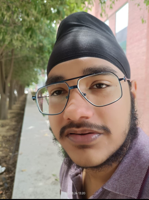

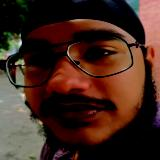

In [14]:
# Display original image
orig = Image.open(test_img_path)
orig.thumbnail((200,200))
display(orig)

# Display all cropped faces
for f in os.listdir(output_dir):
    if f.endswith((".jpg", ".jpeg", ".png")):
        display(Image.open(os.path.join(output_dir, f)))


### Phase 1, part 1: face detection & cropping

In [16]:
IMG_DIR = r"C:\Users\Archit\Desktop\Frendclassifier\Images\ALL_Images"
CROP_DIR = r"C:\Users\Archit\Desktop\Frendclassifier\Images\Cropped"

In [17]:
all_images = [f for f in os.listdir(IMG_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))]

for img_file in tqdm(all_images):
    img_path = os.path.join(IMG_DIR, img_file)
    img = Image.open(img_path)

    faces, probs = mtcnn(img, return_prob=True)

    if faces is not None:
        for i, (face, prob) in enumerate(zip(faces, probs)):
            if prob > 0.9:  # confidence threshold
                out_path = os.path.join(CROP_DIR, f"{os.path.splitext(img_file)[0]}_face{i+1}.jpg")
                face_np = (face.permute(1, 2, 0).clamp(0,1).numpy() * 255).astype(np.uint8)
                face_img = Image.fromarray(face_np)
                face_img.save(out_path)

100%|██████████████████████████████████████████████████████████████| 354/354 [00:50<00:00,  7.07it/s]


### S1, part 2 : Generating embeddings 

In [20]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [27]:
root_dir = r"C:\Users\Archit\Desktop\Frendclassifier"

In [28]:
cropped_files = [f for f in os.listdir(CROP_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))]
embeddings = []
filenames = []

for f in tqdm(cropped_files):
    img = Image.open(os.path.join(CROP_DIR, f)).convert('RGB')
    img_tensor = torch.tensor(np.transpose(np.array(img), (2,0,1)), dtype=torch.float32).unsqueeze(0).to(device) / 255.0

    with torch.no_grad():
        emb = resnet(img_tensor).cpu().numpy()
        embeddings.append(emb[0])
        filenames.append(f)

# Save embeddings
embeddings = np.array(embeddings)
np.save(os.path.join(root_dir, "embeddings.npy"), embeddings)
pd.DataFrame({"filename": filenames}).to_csv(os.path.join(root_dir, "embeddings.csv"), index=False)

100%|██████████████████████████████████████████████████████████████| 490/490 [00:07<00:00, 61.98it/s]


In [34]:
# Show first 5 embeddings
for i in range(5):
    print(f"{filenames[i]} embedding:\n", embeddings[i], "\n")

2025-06-14_20_22_19_836_0.jpg_compressed_face1.jpg embedding:
 [ 0.04925591  0.00721303 -0.03901721  0.02919287  0.05488949  0.07254576
  0.00980138  0.00763112 -0.05397453  0.00791038 -0.01069375 -0.00991393
 -0.01741218 -0.07440635 -0.03166175  0.06931692  0.06290474  0.07001364
  0.00374741  0.0266814   0.00922929 -0.04243904 -0.05482291 -0.03964508
  0.00057523  0.01673127  0.04685869  0.02225128 -0.00727173  0.03949386
  0.00156796 -0.02205163 -0.02350186  0.05148285  0.02423161 -0.03028991
  0.03635897 -0.05447146 -0.02325127  0.05706979 -0.00732321  0.02807557
  0.01571648 -0.02116677 -0.01171769  0.01306044 -0.00862212  0.00042105
 -0.01274718  0.03617131  0.01704068 -0.0107705   0.02486614 -0.00472766
 -0.06267403 -0.02763215  0.00257746  0.01763834 -0.01328972  0.011132
  0.03848717  0.08270361 -0.04571982 -0.03119155 -0.08450165  0.00779871
  0.03855822  0.00154357  0.02382026 -0.03646091 -0.02741123 -0.00952131
 -0.08379381  0.00906404  0.00353943  0.00925042 -0.03669041  0

In [35]:
# Summary statistics
print("Embedding stats:")
print("min:", embeddings.min(), "max:", embeddings.max(), "mean:", embeddings.mean())

Embedding stats:
min: -0.17453854 max: 0.19441573 mean: -9.255891e-05


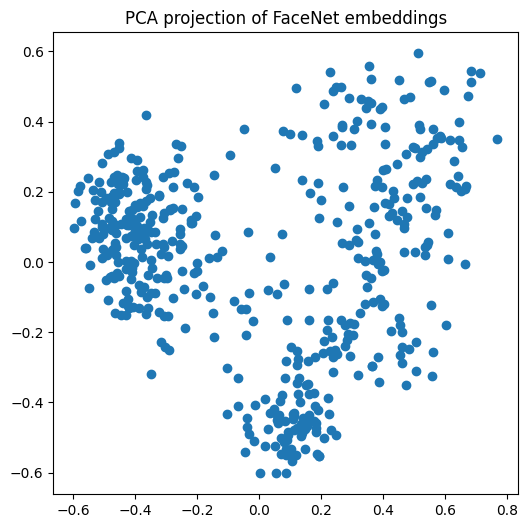

In [36]:
#2D visualization using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1])
plt.title("PCA projection of FaceNet embeddings")
plt.show()

### P1, Step 3 - Clustering embeddings to group faces (unsupervised grouping)

#### K-Means Clustering

In [51]:
from sklearn.cluster import KMeans

# Choose k slightly higher than the number of friends
k = 6  # 5 friends + 2 extra clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

# Save results
import pandas as pd
pd.DataFrame({"filename": filenames, "cluster": kmeans_labels}) \
  .to_csv(r"C:\Users\Archit\Desktop\Frendclassifier\clusters_kmeans.csv", index=False)

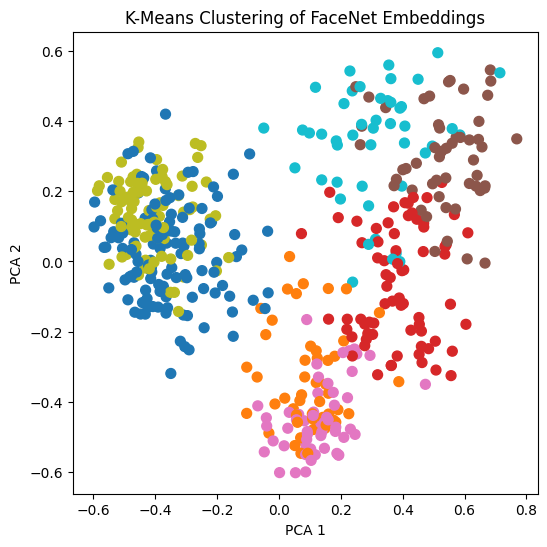

In [50]:
# 2D projection
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=kmeans_labels, cmap='tab10', s=50)
plt.title("K-Means Clustering of FaceNet Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

#### DBSCAN Clustering

In [38]:
from sklearn.cluster import DBSCAN

# Tune eps and min_samples
db = DBSCAN(eps=0.9, min_samples=2, metric='cosine')
db_labels = db.fit_predict(embeddings)

# Save results
pd.DataFrame({"filename": filenames, "cluster": db_labels}) \
  .to_csv(r"C:\Users\Archit\Desktop\Frendclassifier\clusters_dbscan.csv", index=False)

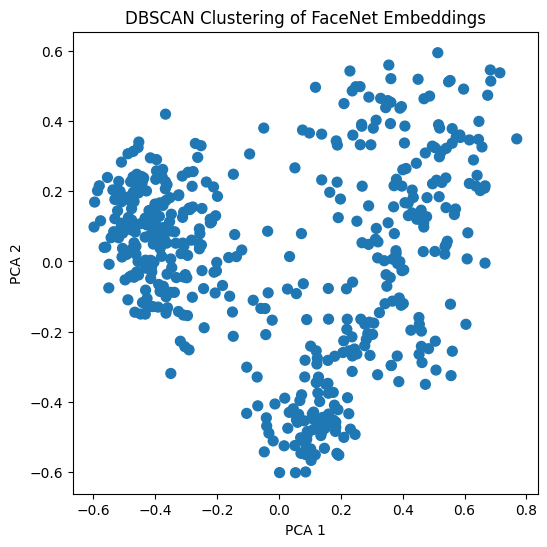

In [42]:
# 2D projection
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

# Map cluster labels to colors
unique_labels = np.unique(db_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
point_colors = [label_color_map[label] for label in db_labels]

# Plot
plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=point_colors, s=50)
plt.title("DBSCAN Clustering of FaceNet Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

## P